## Support Vector Machine Models

## Load Data

In [3]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import time

In [4]:
images_train = np.load("../data/images/images_train.npy")
images_test = np.load("../data/images/images_test.npy")
num_samples_train = images_train.shape[0]
num_samples_test = images_test.shape[0]

images_train = images_train.reshape(num_samples_train, -1)
images_test = images_test.reshape(num_samples_test, -1)

hog_train = np.load("../data/hog/hog_train.npy").reshape(num_samples_train, -1)
hog_train = hog_train * 255
hog_test = np.load("../data/hog/hog_test.npy").reshape(num_samples_test, -1)
hog_test = hog_test * 255

canny_edges_train  = np.load("../data/canny_edges/canny_edges_train.npy").reshape(num_samples_train, -1)
canny_edges_test  = np.load("../data/canny_edges/canny_edges_test.npy").reshape(num_samples_test, -1)

contours_train = np.load("../data/contours/contours_train.npy").reshape(num_samples_train, -1)
contours_test = np.load("../data/contours/contours_test.npy").reshape(num_samples_test, -1)

y_train = np.load("../data/images/label_ids_train.npy")
y_test = np.load("../data/images/label_ids_test.npy")


In [5]:
labels_train = np.load("../data/images/labels_train.npy")
class_lookup = list(set(zip(y_train, labels_train)))
class_lookup = {id_value: class_value for id_value, class_value in class_lookup}
class_lookup
sorted_class_lookup = {k: class_lookup[k] for k in sorted(class_lookup)}
label_names = list(sorted_class_lookup.values())

In [6]:
def show_confusion_matrix(confusion_matrix):
  ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                  xticklabels=label_names, yticklabels=label_names, cbar=False)

  # Add axis labels.
  ax.set(xlabel='Predicted Label', ylabel='True Label')
  plt.show()

In [7]:
def show_roc_curve(y_score, y_test):
  # Binarize the output
  y_test_bin = label_binarize(y_test, classes=list(range(10)))
  n_classes = y_test_bin.shape[1]
  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  for i in range(n_classes):
      plt.figure()
      plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc[i]:.2f})')
      plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title(f'Receiver Operating Characteristic for {label_names[i]}')
      plt.legend(loc="lower right")
      plt.show()

##Hyperparameter Search

In [8]:
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

svm = SVC(max_iter=10000, probability=True)
rand_search = RandomizedSearchCV(estimator=svm,  param_distributions=param_grid_svm, n_iter=3, cv=3, n_jobs=-1, scoring='accuracy', random_state=42)

## Model 1: Images Only

In [9]:
#model = SVC(max_iter=10000, kernel='linear', probability=True)
#model.fit(images_train, y_train)
start_time = time.time()
rand_search.fit(images_train, y_train)
training_time = time.time() - start_time
print(f"Training time: {training_time:.2f} seconds")
# Print the best parameters and score
print(f"Best parameters: {rand_search.best_params_}")
print(f"Best score: {rand_search.best_score_}")

Training time: 1629.14 seconds
Best parameters: {'kernel': 'poly', 'gamma': 'scale', 'C': 1}
Best score: 0.21030057413036138


In [10]:
#y_pred = model.predict(images_test)
model = rand_search.best_estimator_
#y_pred = model.predict(images_test)
start_time = time.time()
y_pred = model.predict(images_test)
inference_time = time.time() - start_time
print(f"Inference time: {inference_time:.2f} seconds")

Inference time: 6.42 seconds


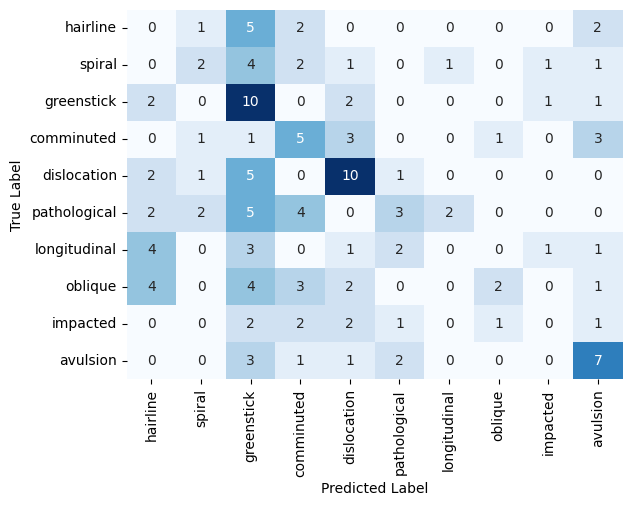

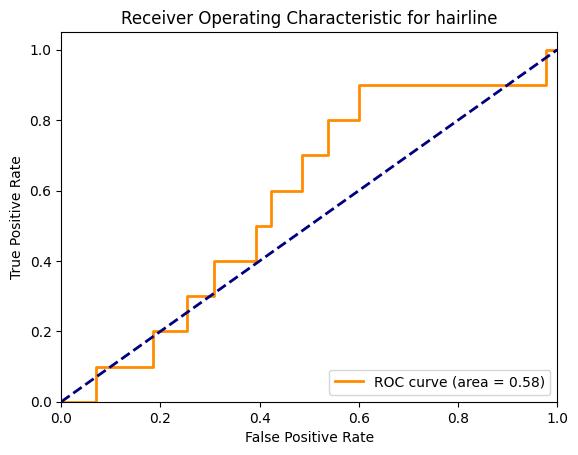

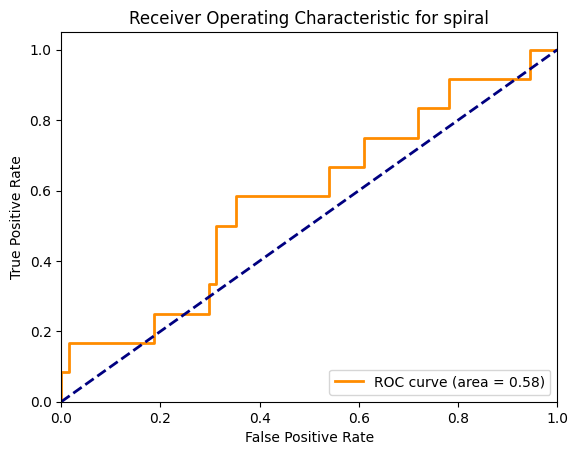

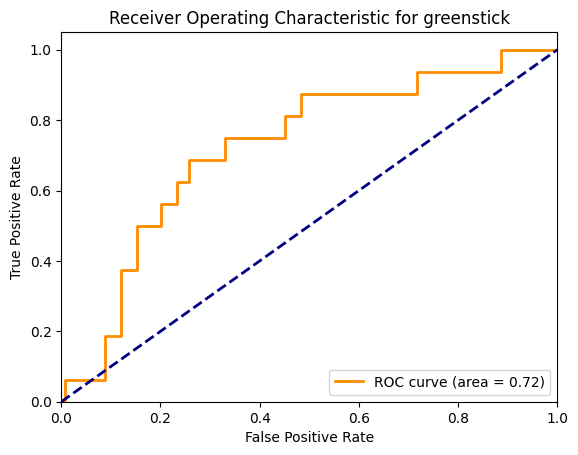

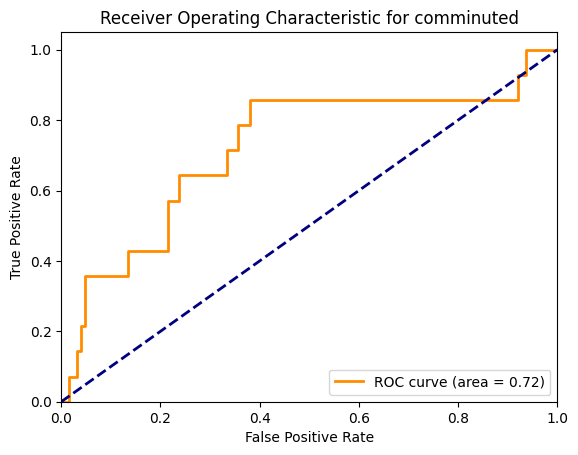

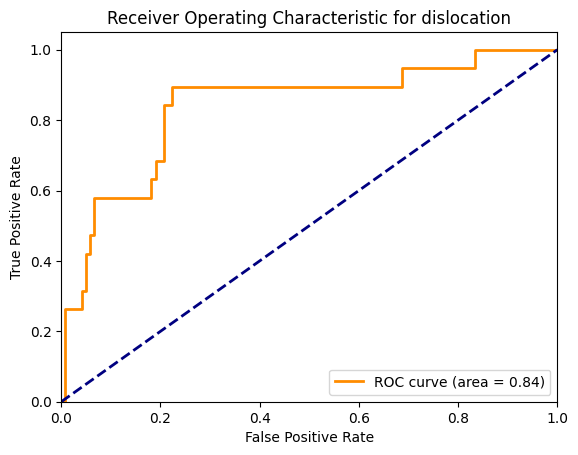

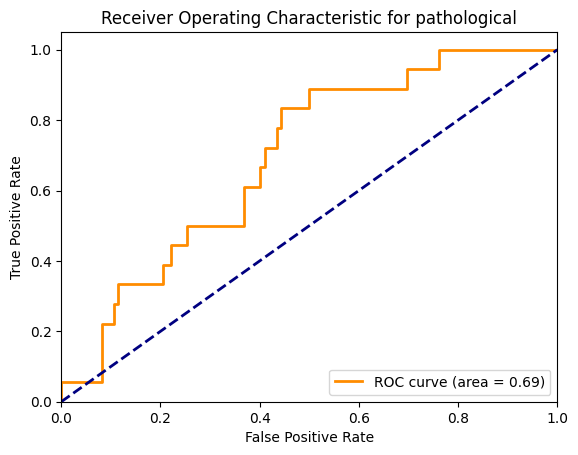

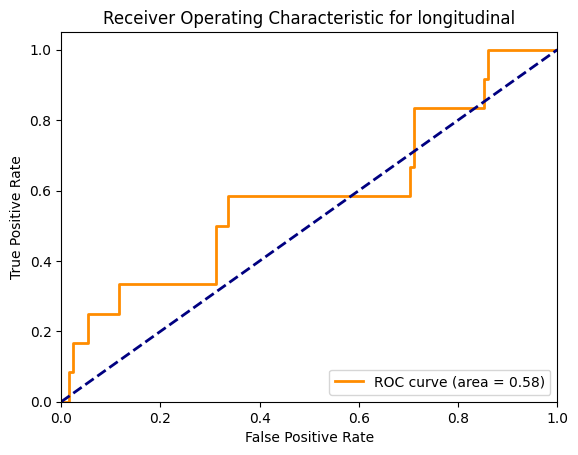

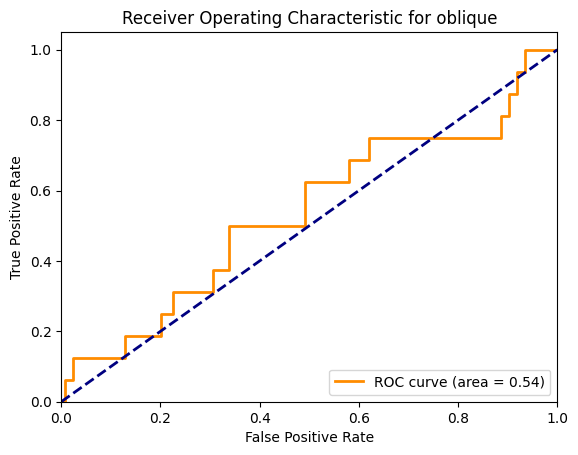

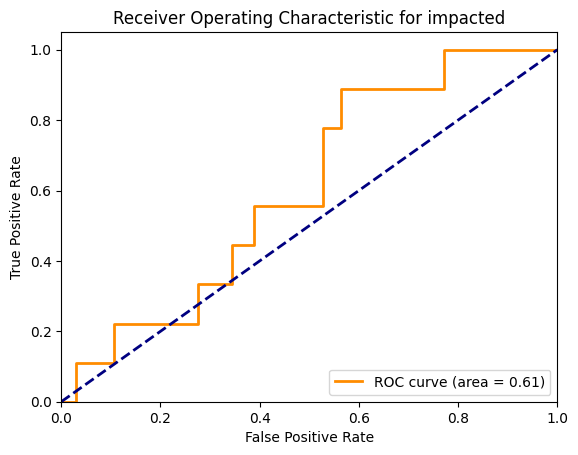

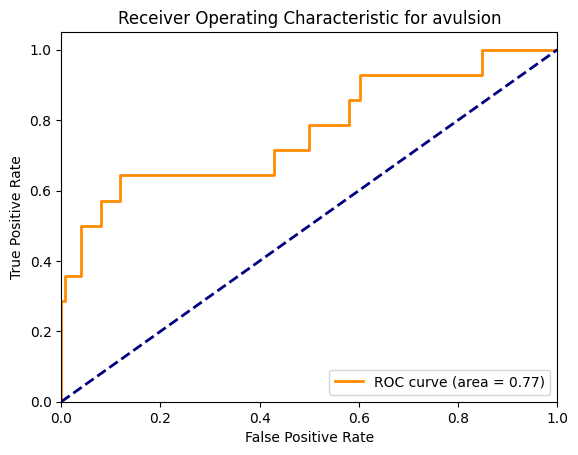

Accuracy: 0.2785714285714286
Classification Report:


,precision,recall,f1-score,support
hairline,0.000000,0.000000,0.000000,10.000000
spiral,0.285714,0.166667,0.210526,12.000000
greenstick,0.238095,0.625000,0.344828,16.000000
comminuted,0.263158,0.357143,0.303030,14.000000
dislocation,0.454545,0.526316,0.487805,19.000000
pathological,0.333333,0.166667,0.222222,18.000000
longitudinal,0.000000,0.000000,0.000000,12.000000
oblique,0.500000,0.125000,0.200000,16.000000
impacted,0.000000,0.000000,0.000000,9.000000
avulsion,0.411765,0.500000,0.451613,14.000000


In [11]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = model.predict_proba(images_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report

## Model 2: HOG Feature Only

In [12]:
#model = SVC(max_iter=10000, kernel='linear', probability=True)
#model.fit(hog_train, y_train)
start_time = time.time()
rand_search.fit(hog_train, y_train)
training_time = time.time() - start_time
print(f"Training time: {training_time:.2f} seconds")
# Print the best parameters and score
print(f"Best parameters: {rand_search.best_params_}")
print(f"Best score: {rand_search.best_score_}")

Training time: 1776.02 seconds
Best parameters: {'kernel': 'linear', 'gamma': 'scale', 'C': 0.1}
Best score: 0.22242792668324585


In [13]:
#y_pred = model.predict(hog_test)
model = rand_search.best_estimator_
#y_pred = model.predict(images_test)
start_time = time.time()
y_pred = model.predict(hog_test)
inference_time = time.time() - start_time
print(f"Inference time: {inference_time:.2f} seconds")

Inference time: 4.81 seconds


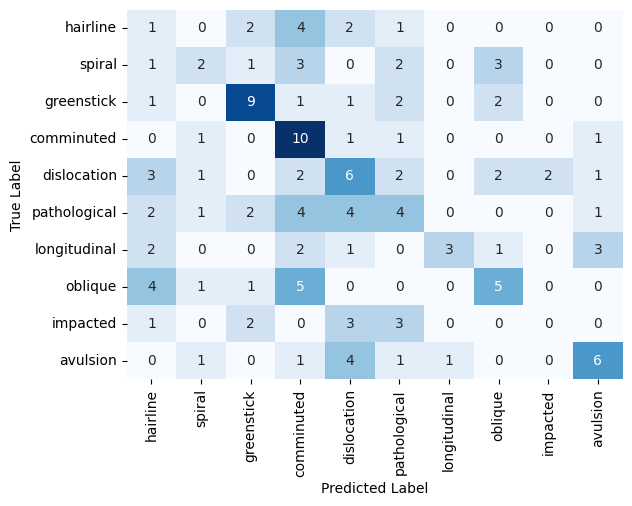

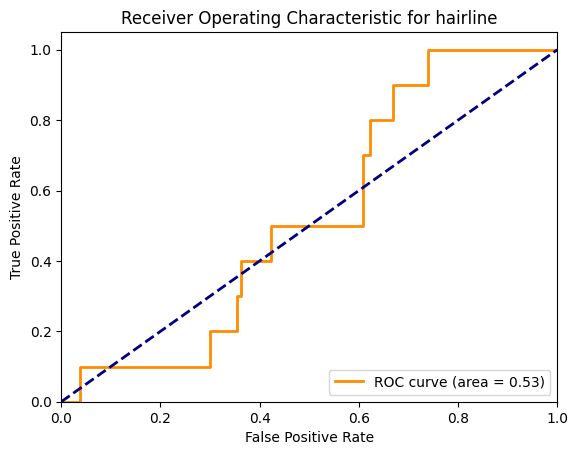

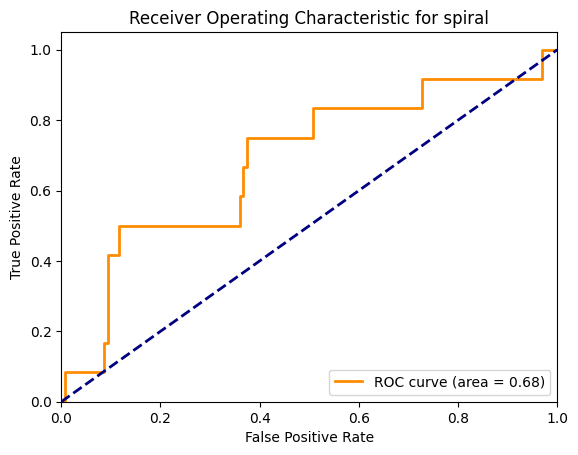

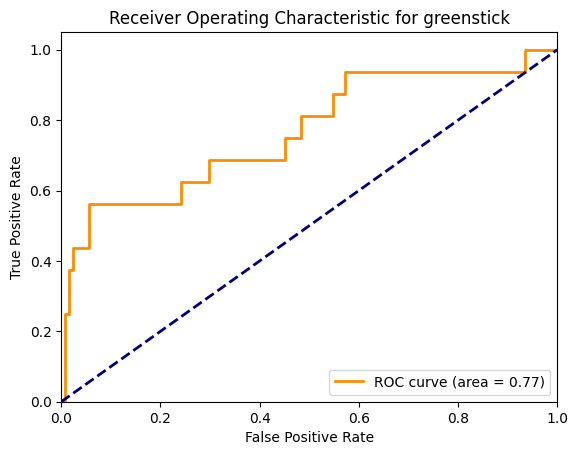

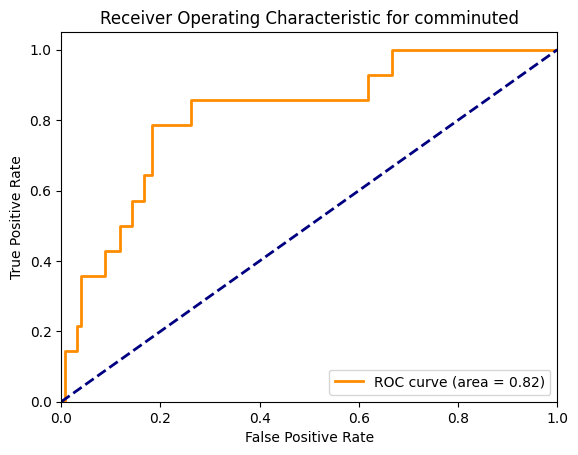

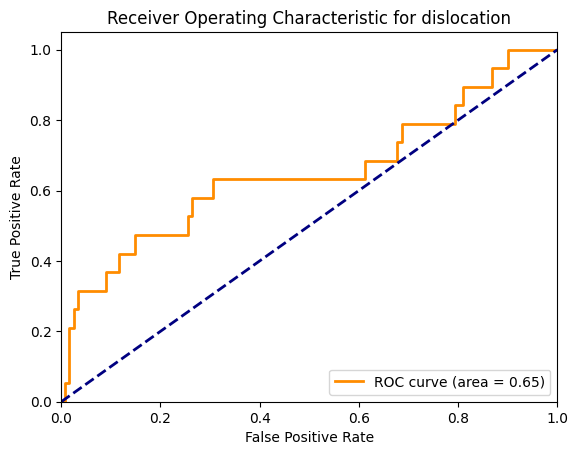

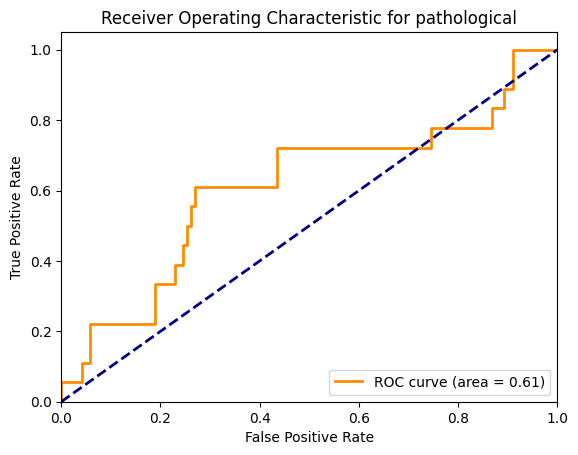

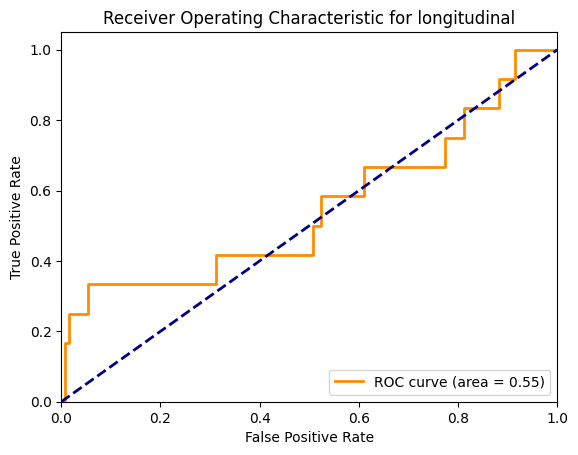

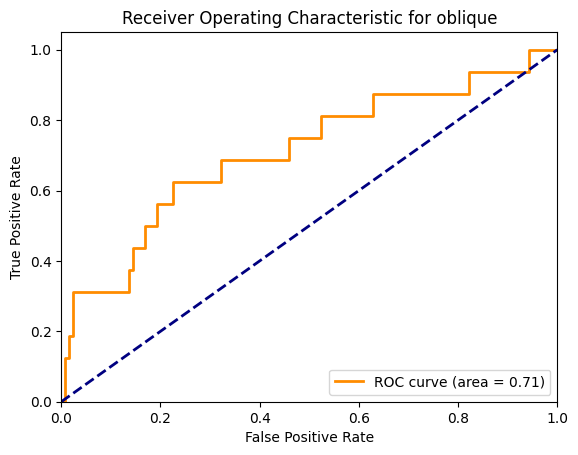

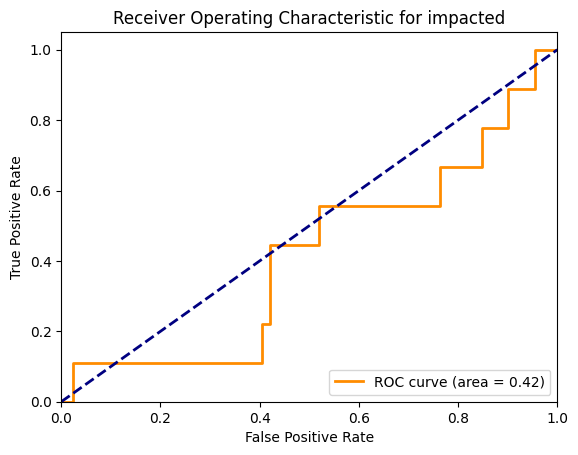

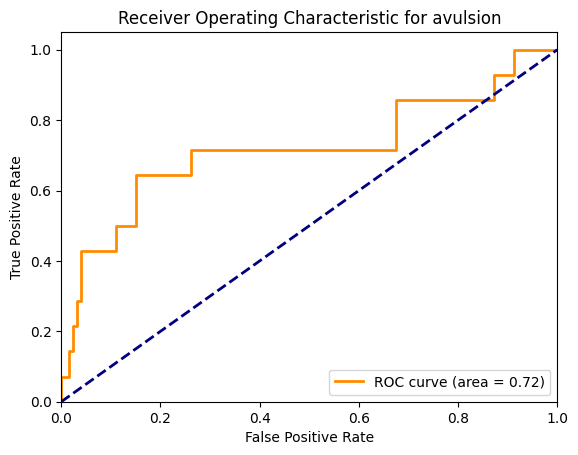

Accuracy: 0.32857142857142857
Classification Report:


,precision,recall,f1-score,support
hairline,0.066667,0.100000,0.080000,10.000000
spiral,0.285714,0.166667,0.210526,12.000000
greenstick,0.529412,0.562500,0.545455,16.000000
comminuted,0.312500,0.714286,0.434783,14.000000
dislocation,0.272727,0.315789,0.292683,19.000000
pathological,0.250000,0.222222,0.235294,18.000000
longitudinal,0.750000,0.250000,0.375000,12.000000
oblique,0.384615,0.312500,0.344828,16.000000
impacted,0.000000,0.000000,0.000000,9.000000
avulsion,0.500000,0.428571,0.461538,14.000000


In [14]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = model.predict_proba(hog_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report

## Model 3: Canny Edges Feature Only

In [15]:
#model = SVC(max_iter=10000, kernel='linear', probability=True)
#model.fit(canny_edges_train, y_train)
start_time = time.time()
rand_search.fit(canny_edges_train, y_train)
training_time = time.time() - start_time
print(f"Training time: {training_time:.2f} seconds")
# Print the best parameters and score
print(f"Best parameters: {rand_search.best_params_}")
print(f"Best score: {rand_search.best_score_}")

Training time: 1758.80 seconds
Best parameters: {'kernel': 'linear', 'gamma': 'scale', 'C': 0.1}
Best score: 0.15569371526818335


In [16]:
#y_pred = model.predict(canny_edges_test)
model = rand_search.best_estimator_
#y_pred = model.predict(images_test)
start_time = time.time()
y_pred = model.predict(canny_edges_test)
inference_time = time.time() - start_time
print(f"Inference time: {inference_time:.2f} seconds")

Inference time: 5.08 seconds


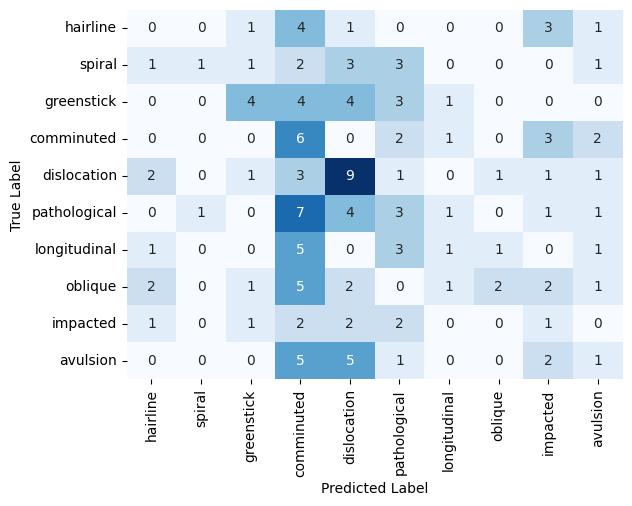

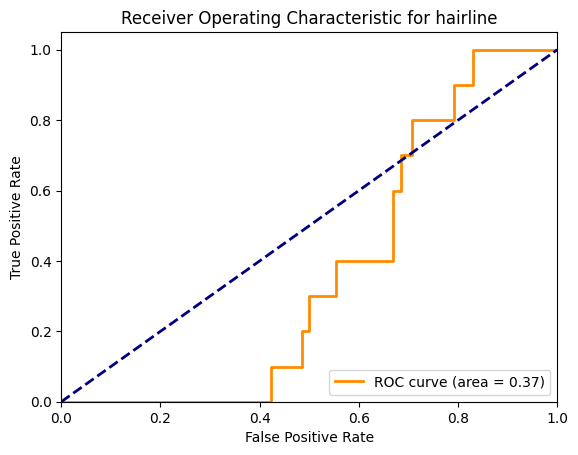

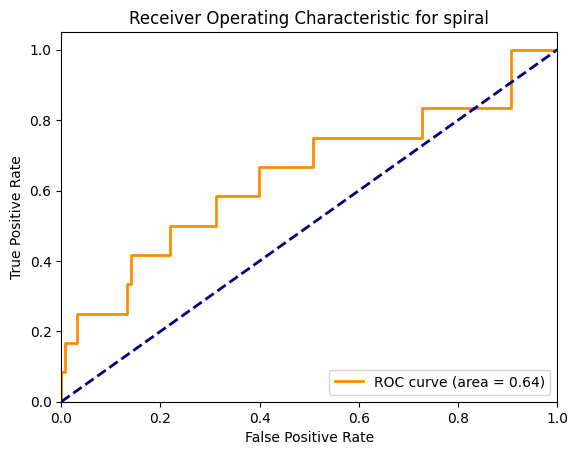

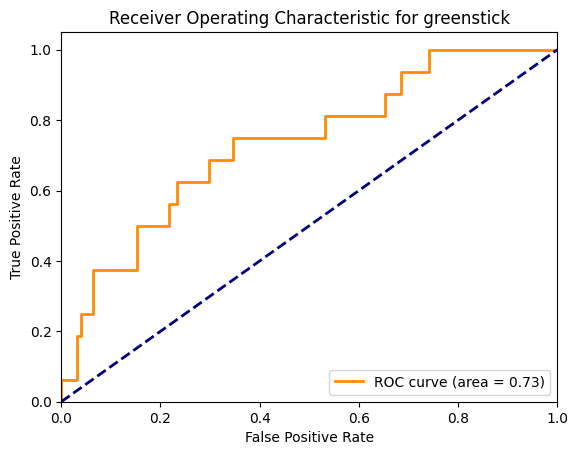

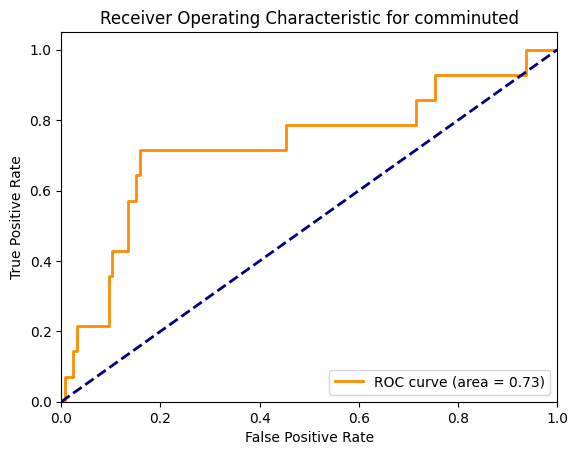

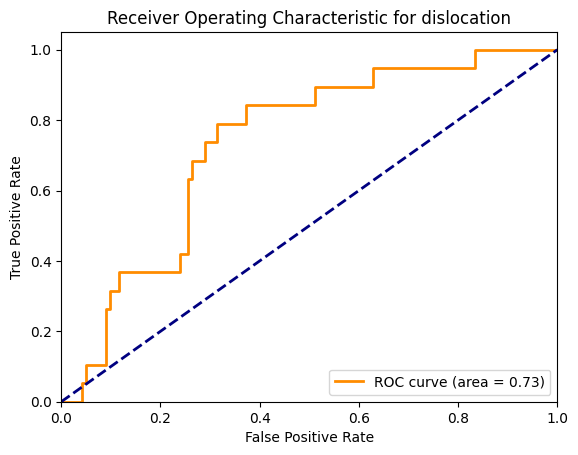

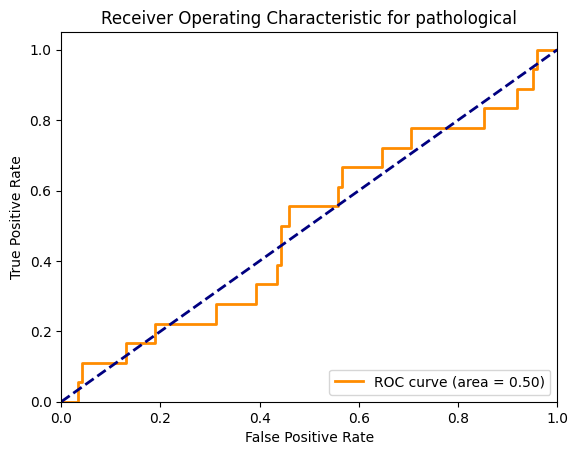

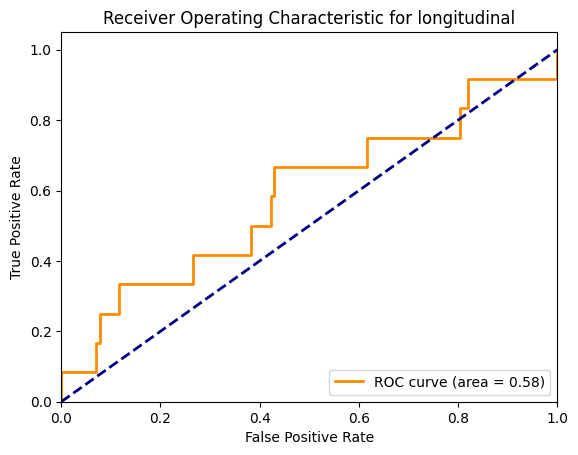

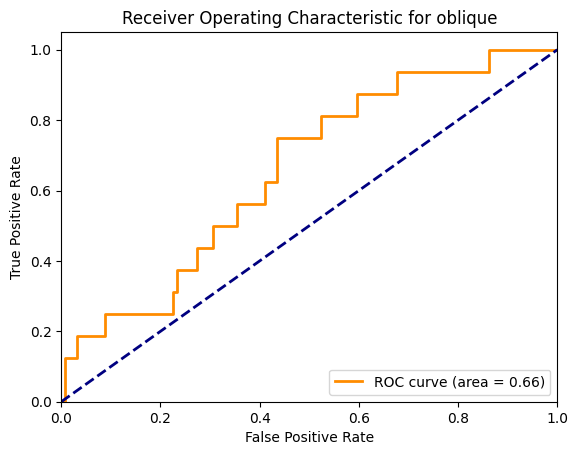

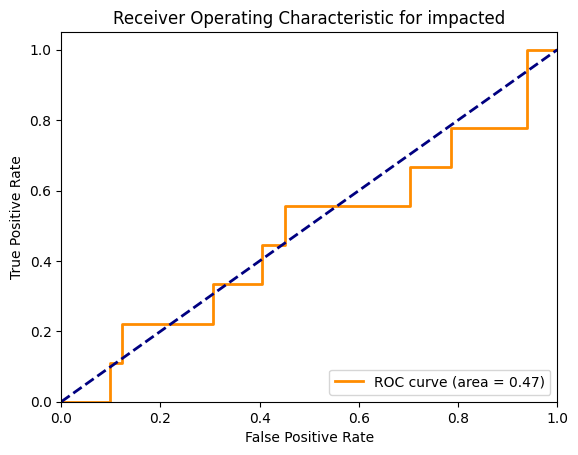

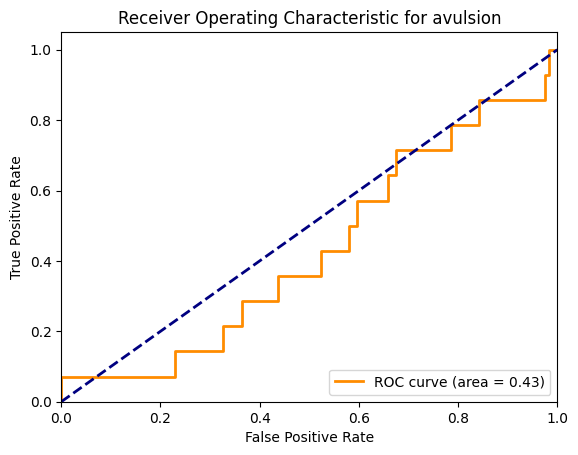

Accuracy: 0.2
Classification Report:


,precision,recall,f1-score,support
hairline,0.000000,0.000000,0.000000,10.0
spiral,0.500000,0.083333,0.142857,12.0
greenstick,0.444444,0.250000,0.320000,16.0
comminuted,0.139535,0.428571,0.210526,14.0
dislocation,0.300000,0.473684,0.367347,19.0
pathological,0.166667,0.166667,0.166667,18.0
longitudinal,0.200000,0.083333,0.117647,12.0
oblique,0.500000,0.125000,0.200000,16.0
impacted,0.076923,0.111111,0.090909,9.0
avulsion,0.111111,0.071429,0.086957,14.0


In [17]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = model.predict_proba(canny_edges_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report

## Model 4: Contours Feature Only

In [18]:
#model = SVC(max_iter=10000, kernel='linear', probability=True)
#model.fit(contours_train, y_train)
start_time = time.time()
rand_search.fit(contours_train, y_train)
training_time = time.time() - start_time
print(f"Training time: {training_time:.2f} seconds")
# Print the best parameters and score
print(f"Best parameters: {rand_search.best_params_}")
print(f"Best score: {rand_search.best_score_}")

Training time: 1755.74 seconds
Best parameters: {'kernel': 'linear', 'gamma': 'scale', 'C': 0.1}
Best score: 0.16985048048877835


In [19]:
#y_pred = model.predict(contours_test)
model = rand_search.best_estimator_
#y_pred = model.predict(images_test)
start_time = time.time()
y_pred = model.predict(contours_test)
inference_time = time.time() - start_time
print(f"Inference time: {inference_time:.2f} seconds")

Inference time: 5.12 seconds


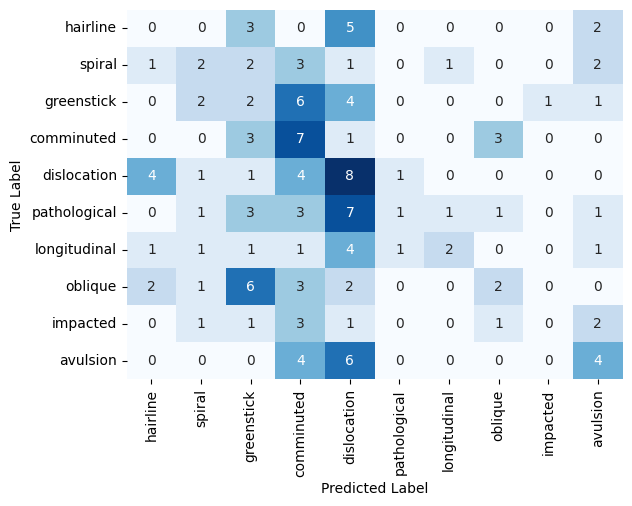

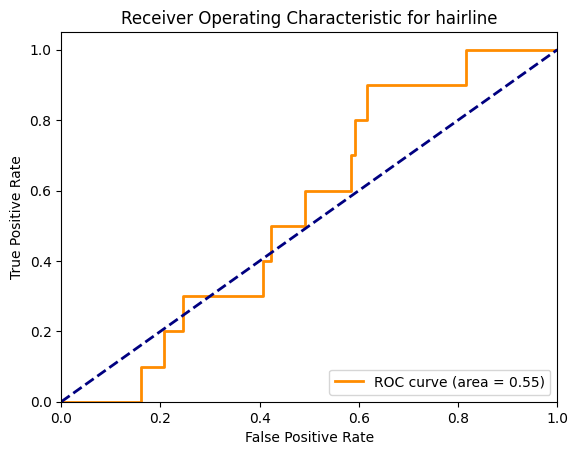

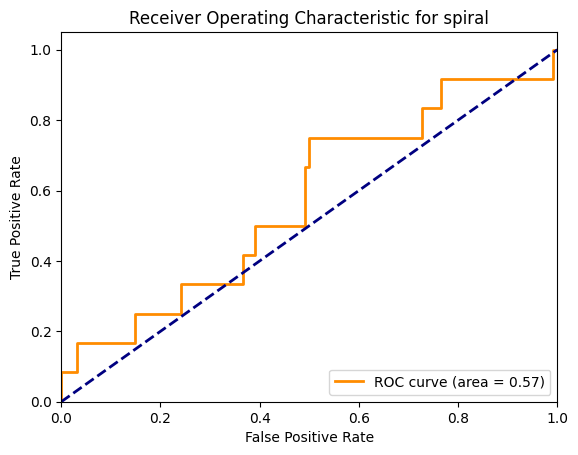

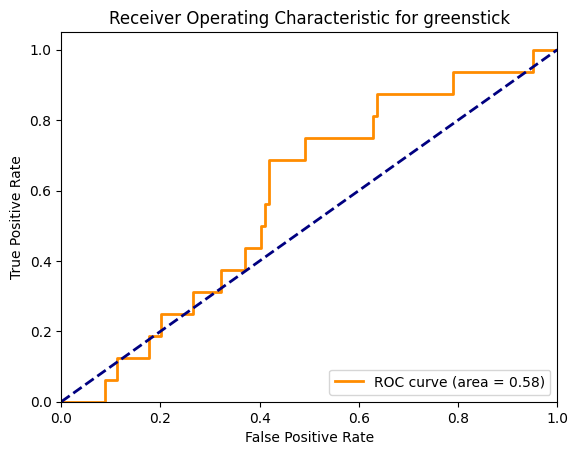

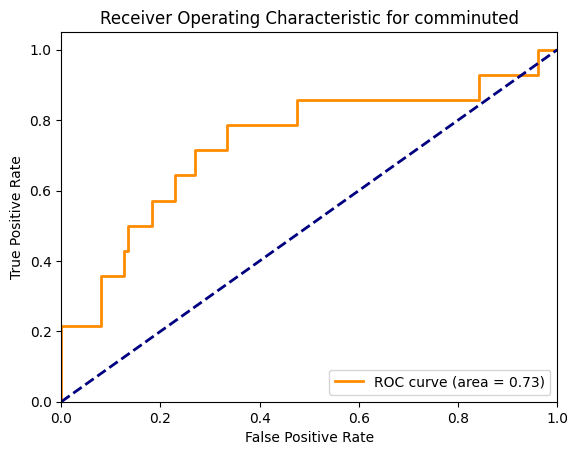

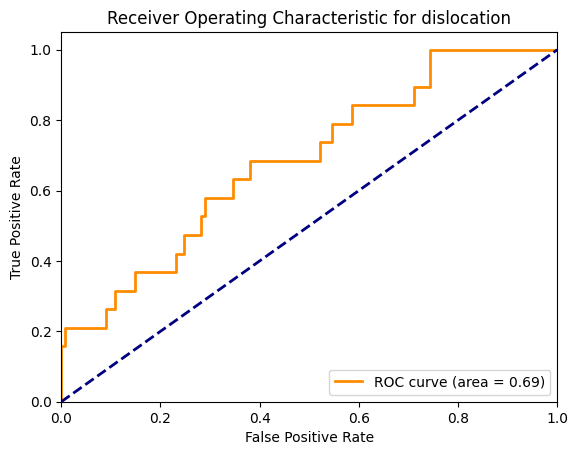

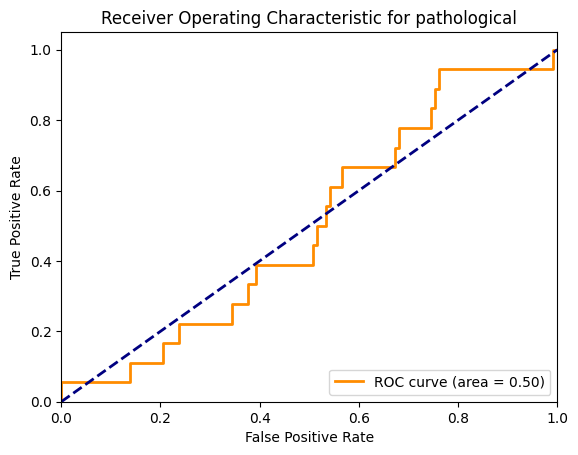

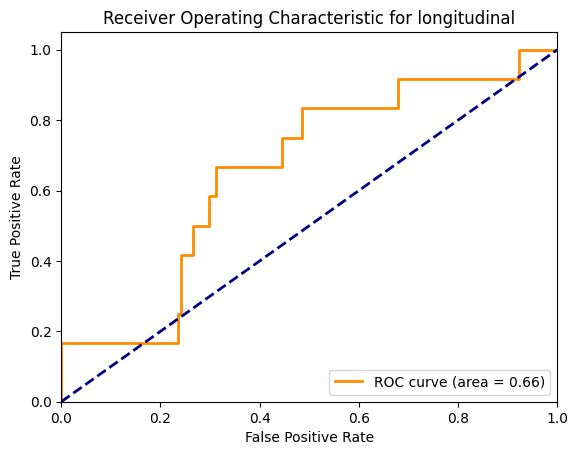

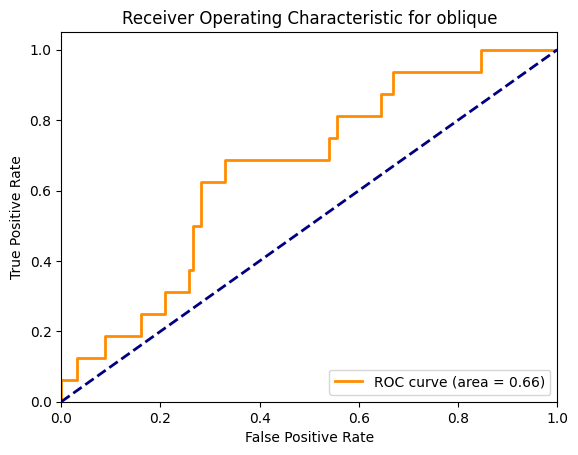

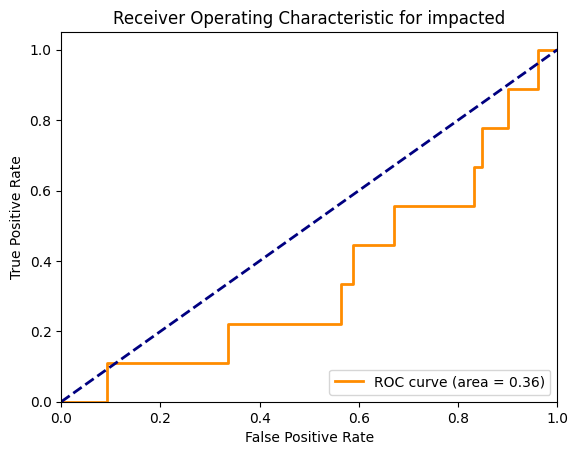

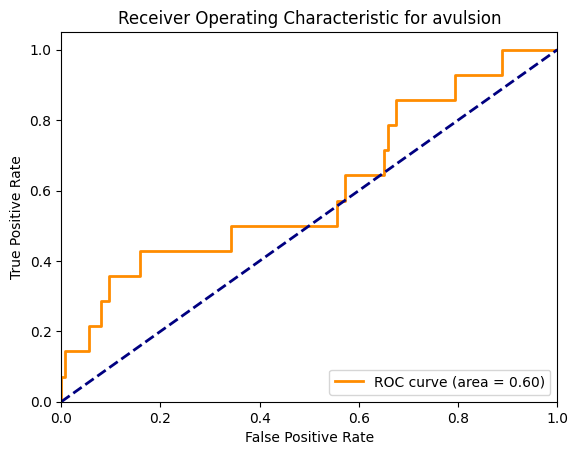

Accuracy: 0.2
Classification Report:


,precision,recall,f1-score,support
hairline,0.000000,0.000000,0.000000,10.0
spiral,0.222222,0.166667,0.190476,12.0
greenstick,0.090909,0.125000,0.105263,16.0
comminuted,0.205882,0.500000,0.291667,14.0
dislocation,0.205128,0.421053,0.275862,19.0
pathological,0.333333,0.055556,0.095238,18.0
longitudinal,0.500000,0.166667,0.250000,12.0
oblique,0.285714,0.125000,0.173913,16.0
impacted,0.000000,0.000000,0.000000,9.0
avulsion,0.307692,0.285714,0.296296,14.0


In [20]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = model.predict_proba(contours_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report

## Model 5: Best Combination

In [9]:
X_train = np.hstack((images_train, hog_train, canny_edges_train, contours_train))
X_test = np.hstack((images_test, hog_test, canny_edges_test, contours_test))

In [10]:
#model = SVC(max_iter=10000, kernel='linear', probability=True)
#model.fit(X_train, y_train)
start_time = time.time()
rand_search.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"Training time: {training_time:.2f} seconds")
# Print the best parameters and score
print(f"Best parameters: {rand_search.best_params_}")
print(f"Best score: {rand_search.best_score_}")

Training time: 8783.28 seconds
Best parameters: {'kernel': 'linear', 'gamma': 'scale', 'C': 0.1}
Best score: 0.1991863928034141


In [11]:
#y_pred = model.predict(X_test)
model = rand_search.best_estimator_
#y_pred = model.predict(images_test)
start_time = time.time()
y_pred = model.predict(X_test)
inference_time = time.time() - start_time
print(f"Inference time: {inference_time:.2f} seconds")

Inference time: 21.78 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


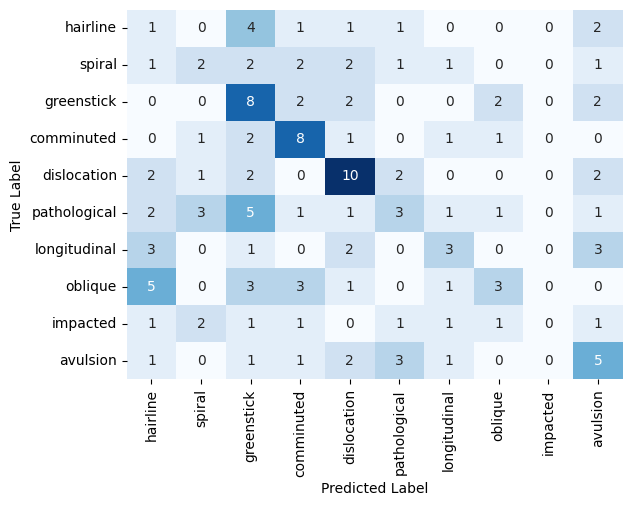

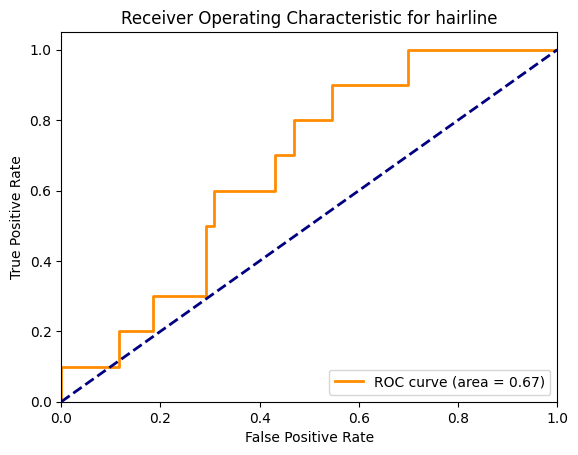

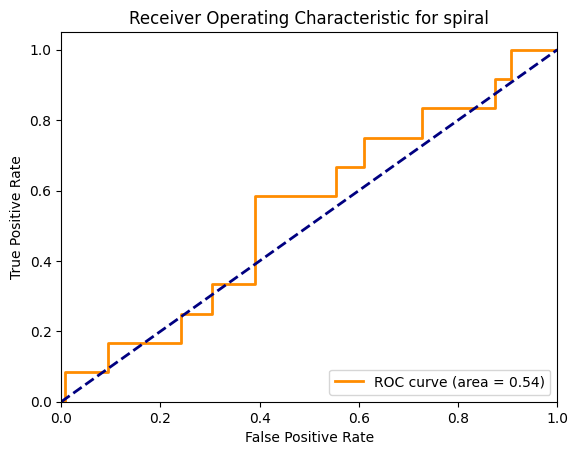

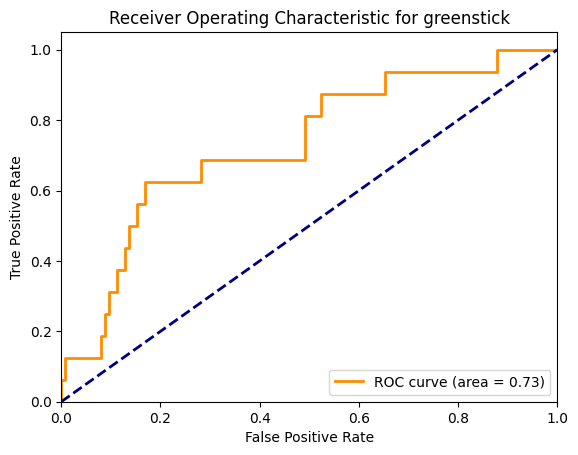

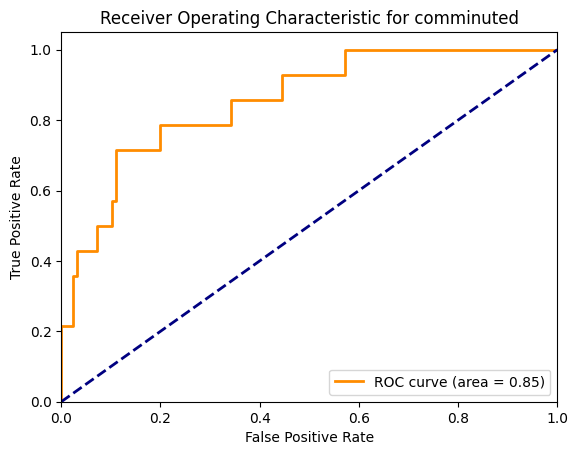

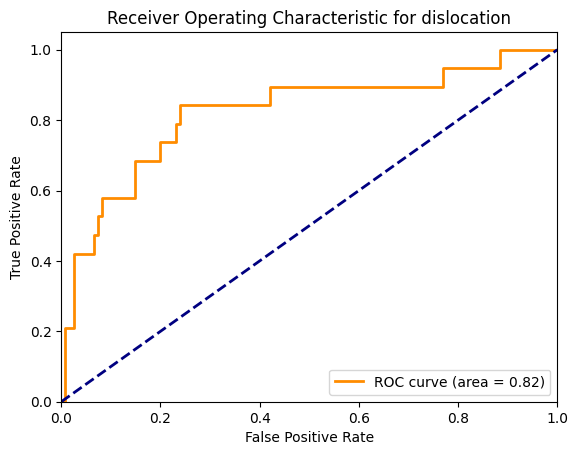

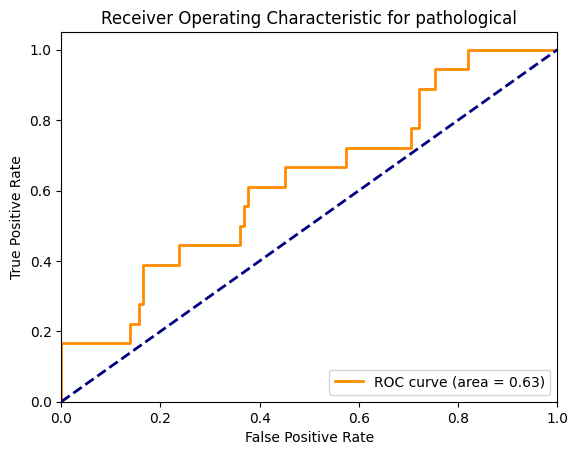

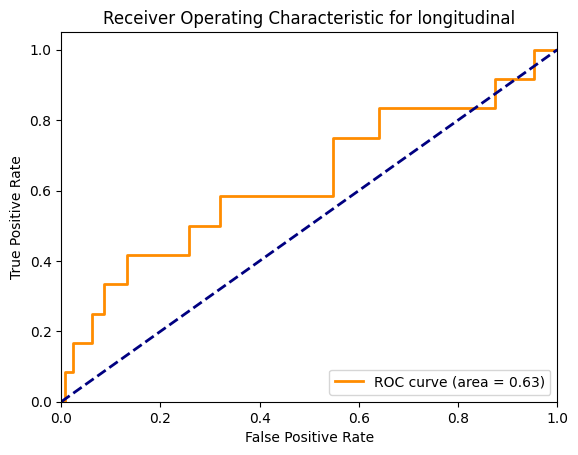

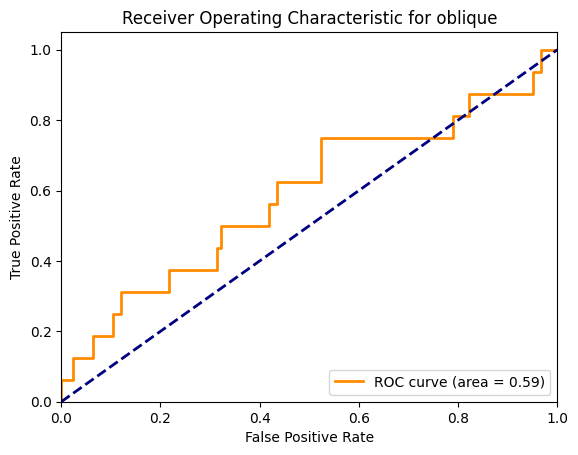

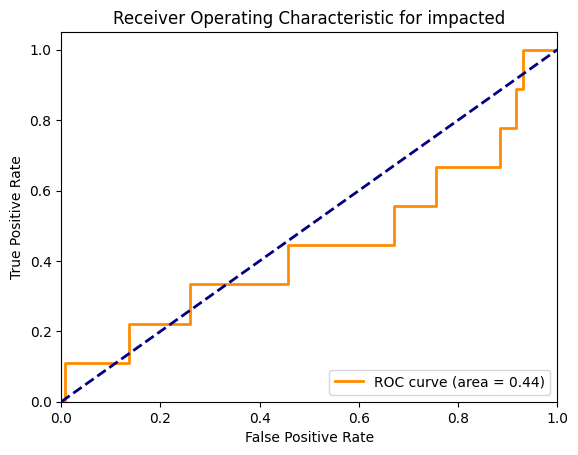

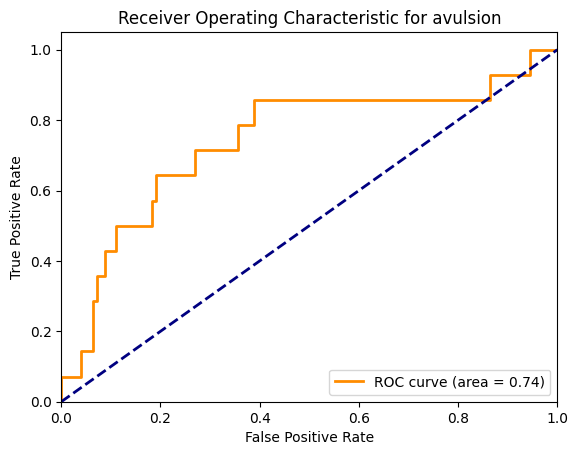

Accuracy: 0.30714285714285716
Classification Report:


,precision,recall,f1-score,support
hairline,0.062500,0.100000,0.076923,10.000000
spiral,0.222222,0.166667,0.190476,12.000000
greenstick,0.275862,0.500000,0.355556,16.000000
comminuted,0.421053,0.571429,0.484848,14.000000
dislocation,0.454545,0.526316,0.487805,19.000000
pathological,0.272727,0.166667,0.206897,18.000000
longitudinal,0.333333,0.250000,0.285714,12.000000
oblique,0.375000,0.187500,0.250000,16.000000
impacted,0.000000,0.000000,0.000000,9.000000
avulsion,0.294118,0.357143,0.322581,14.000000


In [12]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = model.predict_proba(X_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report